In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount= True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
!ls

gdrive	sample_data


In [ ]:
# !pwd
%cd gdrive/My Drive/Colab Notebooks/WS_new
# !ls

/content/gdrive/My Drive/Colab Notebooks/WS_new


**Import Packages**

In [ ]:
!pip install cond-rnn
import time
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from pandas import read_csv
from datetime import datetime
from datetime import datetime
from keras.models import Sequential
from keras.layers import LSTM, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Dense, Input
from cond_rnn import ConditionalRNN
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

**Load Dataset**

In [ ]:
dataset = read_csv('df1.csv', index_col=0)
dataset.index.name = 'date'
dataset = dataset.iloc[:, 1:1067]
print(dataset.head(5))

             WS       WS.1       WS.2  ...   WS.1063   WS.1064   WS.1065
date                                   ...                              
1     10.071163   9.942720   9.551888  ...  6.828917  6.489227  6.270858
2     15.330322  13.908545  11.744733  ...  7.930633  7.793883  7.478707
3     10.116735   8.829069   7.486993  ...  4.549035  4.360729  4.113177
4      6.372461   6.079538   6.120785  ...  3.959986  4.183685  4.373534
5      3.652555   4.436350   5.304547  ...  3.622330  3.753542  3.796246

[5 rows x 1066 columns]


**Creat a function to transform the dataset to fit the model**

In [ ]:
from pandas import DataFrame
from pandas import concat
 

def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

**Transform and scale the dataset**

In [ ]:
values = dataset.values
values = values.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
reframed = series_to_supervised(scaled, 3, 1)
print(reframed.head())

   var1(t-3)  var2(t-3)  var3(t-3)  ...  var1064(t)  var1065(t)  var1066(t)
3   0.424114   0.432618   0.450136  ...    0.247527    0.263525    0.260752
4   0.666204   0.621328   0.562610  ...    0.220491    0.230561    0.214355
5   0.426212   0.379626   0.344225  ...    0.099044    0.137507    0.143901
6   0.253856   0.248792   0.274150  ...    0.347335    0.366652    0.361911
7   0.128653   0.170603   0.232284  ...    0.462283    0.434013    0.398894

[5 rows x 4264 columns]


In [ ]:
values = reframed.values
train = values[:13149, :]
test = values[13149:, :]
train_X, train_y = train[:, 0:3198], train[:, 3198:4264]
test_X, test_y = test[:, 0:3198], test[:, 3198:4264]

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Reshape, Input
from keras.layers import LSTM, Conv2D, BatchNormalization, Conv2DTranspose
from keras.regularizers import l2
from keras.layers.wrappers import TimeDistributed
import tensorflow as tf
import numpy as np

In [ ]:
model2 = Sequential()
model2.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model2.add(Dense(1066))
model2.compile(loss='mse', optimizer='adam')
history2 = model2.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)

Epoch 1/50
183/183 - 2s - loss: 0.0182 - val_loss: 0.0123
Epoch 2/50
183/183 - 2s - loss: 0.0118 - val_loss: 0.0109
Epoch 3/50
183/183 - 2s - loss: 0.0109 - val_loss: 0.0102
Epoch 4/50
183/183 - 3s - loss: 0.0104 - val_loss: 0.0100
Epoch 5/50
183/183 - 3s - loss: 0.0101 - val_loss: 0.0098
Epoch 6/50
183/183 - 3s - loss: 0.0099 - val_loss: 0.0096
Epoch 7/50
183/183 - 2s - loss: 0.0098 - val_loss: 0.0095
Epoch 8/50
183/183 - 2s - loss: 0.0096 - val_loss: 0.0094
Epoch 9/50
183/183 - 2s - loss: 0.0095 - val_loss: 0.0093
Epoch 10/50
183/183 - 2s - loss: 0.0094 - val_loss: 0.0092
Epoch 11/50
183/183 - 2s - loss: 0.0093 - val_loss: 0.0092
Epoch 12/50
183/183 - 2s - loss: 0.0092 - val_loss: 0.0092
Epoch 13/50
183/183 - 2s - loss: 0.0091 - val_loss: 0.0091
Epoch 14/50
183/183 - 2s - loss: 0.0091 - val_loss: 0.0090
Epoch 15/50
183/183 - 2s - loss: 0.0090 - val_loss: 0.0090
Epoch 16/50
183/183 - 2s - loss: 0.0089 - val_loss: 0.0090
Epoch 17/50
183/183 - 2s - loss: 0.0089 - val_loss: 0.0089
Epoch 

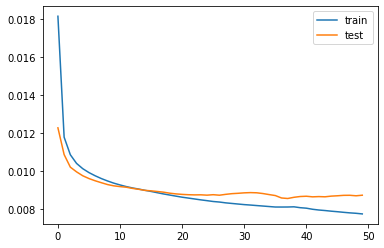

In [ ]:
# 绘制历史数据
plt.plot(history2.history['loss'], label='train')
plt.plot(history2.history['val_loss'], label='test')
plt.legend()
plt.show()